# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


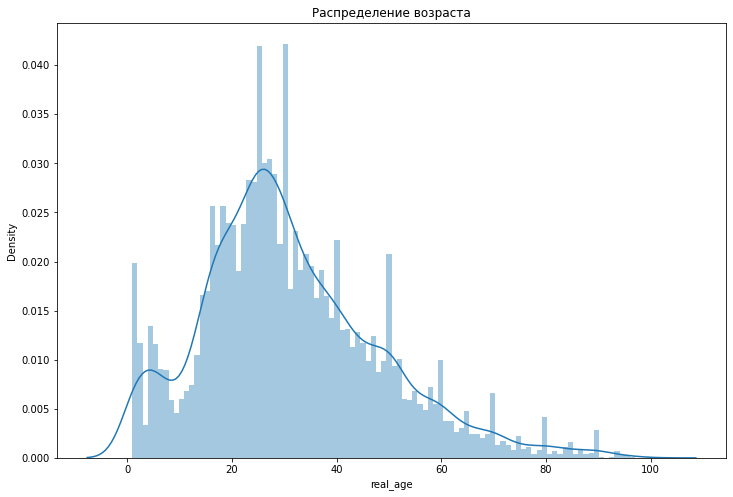

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(labels.real_age, bins=100)
plt.title("Распределение возраста")
plt.show();

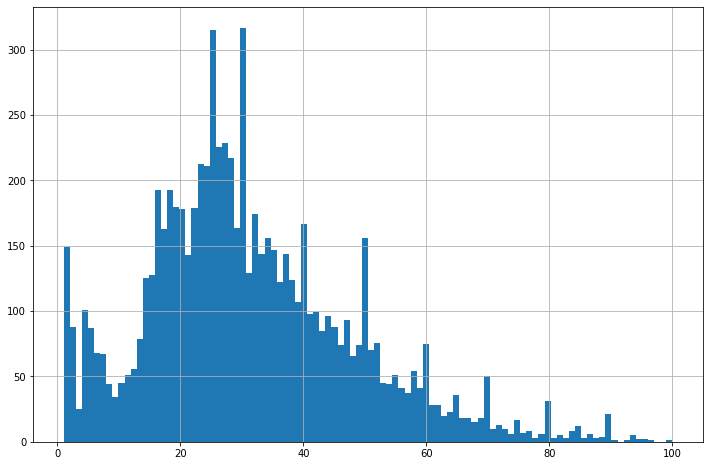

In [6]:
plt.figure(figsize=(12,8))
labels['real_age'].hist(
    bins=100)
    
plt.show()

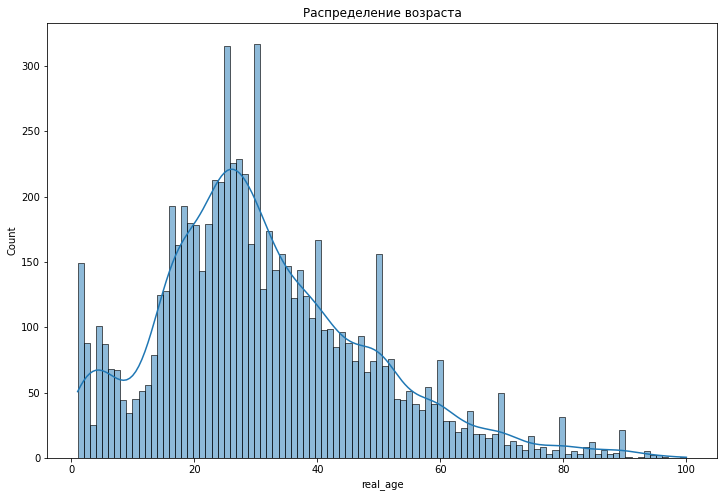

In [10]:
plt.figure(figsize=(12,8))
sns.histplot(labels.real_age, bins=100, kde=True)
plt.title("Распределение возраста")
plt.show();

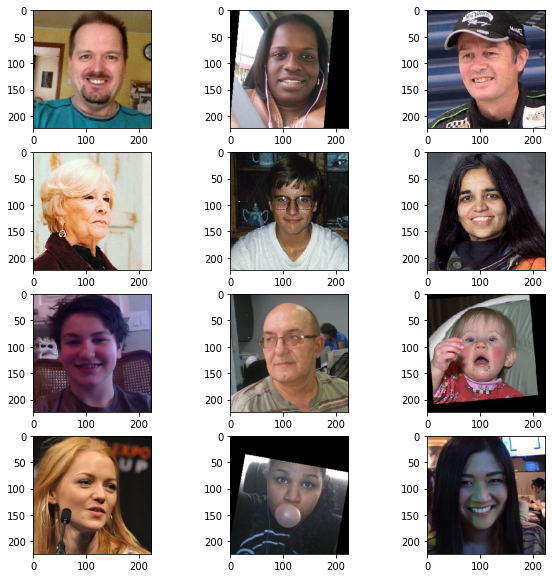

In [7]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    

Распределение похоже на нормальное с несколькими выбросами возможно это связано с округлением возраста или с тем как были получены фотографии- например использовались фотографии в учебных заведениях или на работе.
Выводы.Выборка содержит 7591 изображение,данное число может быть увеличено за счет аугментации.
Выборка состоит из неравномерного количества людей разных возрастов. Так людей от 20 до 30 в ней больше всего , поэтому возможно модель будет угадывать их лучше чем другие возраста. 
Из за того что возраст на фотографиях приблизителен модель может хуже угадывать реальные фото
Также на некоторых фотографиях бывает часть другого человека .
Можно заметить, что некоторые фотографии повернуты, но  это не будет мешать обучению.
Среди фотографий есть как цветные, так и черно-белые. Также фотографии имеют разное качество.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0004)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

   

    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
      
    return model



```

```

2024-01-30 18:56:31.125556: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-01-30 18:56:31.127203: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-01-30 18:56:32.002000: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-01-30 18:56:32.483225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-01-30 18:56:32.483317: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-01-30 18:56:32.483366: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-01-30 18:56:32.485506: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-01-30 18:56:32.486004: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-01-30 18:56:32.488624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-01-30 18:56:32.490269: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-01-30 18:56:32.490353: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-01-30 18:56:32.497539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-01-30 18:56:32.692712: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-01-30 18:56:32.699384: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2024-01-30 18:56:32.700096: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4254cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-30 18:56:32.700127: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-01-30 18:56:32.857051: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x38b4fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-30 18:56:32.857087: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-01-30 18:56:32.858880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-01-30 18:56:32.858944: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-01-30 18:56:32.858954: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-01-30 18:56:32.858981: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-01-30 18:56:32.858990: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-01-30 18:56:32.858999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-01-30 18:56:32.859007: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-01-30 18:56:32.859014: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-01-30 18:56:32.862068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-01-30 18:56:32.862131: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-01-30 18:56:33.182631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-01-30 18:56:33.182686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-01-30 18:56:33.182694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-01-30 18:56:33.185828: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-30 18:56:33.185877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-01-30 18:56:43.475263: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-01-30 18:56:43.769578: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 47s - loss: 210.6934 - mae: 10.7936 - val_loss: 686.3715 - val_mae: 21.2367
Epoch 2/10
178/178 - 39s - loss: 92.2223 - mae: 7.2753 - val_loss: 499.3375 - val_mae: 17.2565
Epoch 3/10
178/178 - 40s - loss: 52.2611 - mae: 5.5895 - val_loss: 363.2207 - val_mae: 14.2178
Epoch 4/10
178/178 - 40s - loss: 33.7374 - mae: 4.4823 - val_loss: 166.8342 - val_mae: 9.6950
Epoch 5/10
178/178 - 40s - loss: 24.3399 - mae: 3.8253 - val_loss: 94.9312 - val_mae: 7.5008
Epoch 6/10
178/178 - 38s - loss: 18.7928 - mae: 3.3294 - val_loss: 120.0490 - val_mae: 8.5982
Epoch 7/10
178/178 - 38s - loss: 13.5058 - mae: 2.8109 - val_loss: 79.1289 - val_mae: 6.6770
Epoch 8/10
178/178 - 38s - loss: 9.9593 - mae: 2.4327 - val_loss: 66.5614 - val_mae: 6.1308
Epoch 9/10
178/178 - 38s - loss: 8.8259 - mae: 2.2858 - val_loss: 67.2386 - val_mae: 6.1143
Epoch 10/10
178/178 - 38s - loss: 7.4092 - mae: 2.0628 - val_loss: 68.8070 - val_mae: 6.2209
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 68.8070 - mae: 6.2209
Test MAE: 6.2209
```

## Анализ обученной модели

В ходе работы были загружены и изучены данные . Распределение фотографий по возрасту похоже на нормальное . Далее 
была обучена модель на основе предобученной архитектуры ResNet50, с обучением нескольких слоев сверху.
Модель построена на основе ResNet50, и в качестве метрики использовалась MAE. 
Модель показала на тестовой выборке неплохой результат - 6.2, это значит, что она сможет определять возраст покупатлей с ошибкой примерно в 6 лет что не критично для рекомендаций товаров  и ее можно внедрять в магазины.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x] Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы